In [5]:
import os
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [6]:
datapath = os.path.join('..', 'data')
filterpath = os.path.join(datapath, 'filters')
num_filters = 16

In [7]:
def visualise_joint(num_rows):
  _, axarr = plt.subplots(num_rows, 16, figsize=(10, num_rows))
  plt.axis('off')
  
  uuids = os.listdir(filterpath)
  for f in range(num_rows):
    file = np.random.choice(uuids, replace=True)
    filter = torch.load(os.path.join(filterpath, file))
    for i in range(16):
      if f < num_rows:
        axarr[f, i].set_axis_off()
        axarr[f, i].imshow(filter['0.weight'][i][0], interpolation=None)

Visualising all filters (joint sampling)

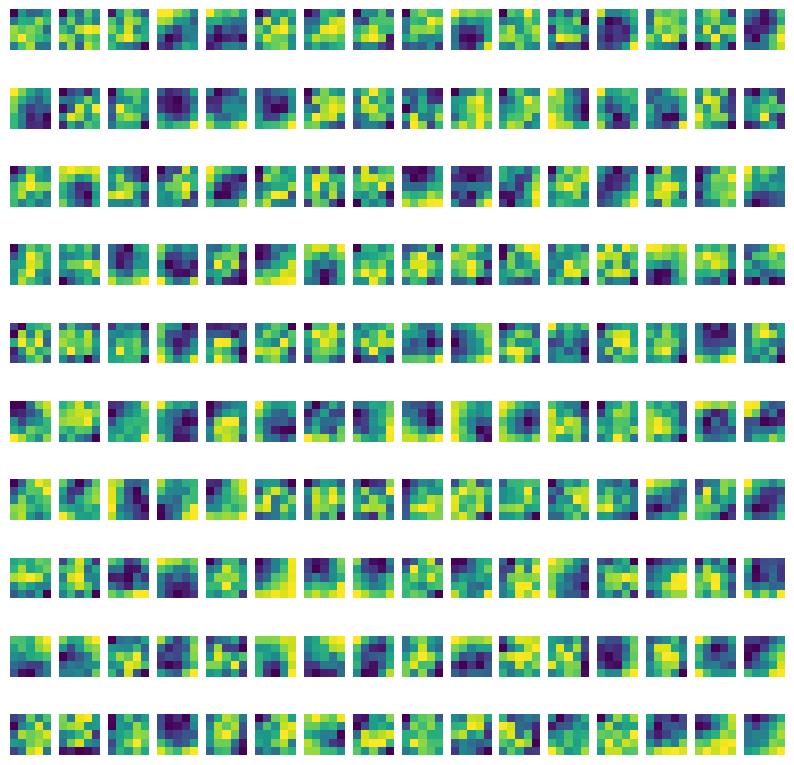

In [8]:
num_images = len(os.listdir(filterpath))
dataset = visualise_joint(10)

Visualising IID sampled filters

In [9]:
def visualise_sampled_IID(num_rows):
    _, axarr = plt.subplots(num_rows, 16, figsize=(10, num_rows))
    plt.axis('off')

    uuids = os.listdir(filterpath)
    for f in range(num_rows):
        for i in range(16):
            file = np.random.choice(uuids, replace=True)
            filter = torch.load(os.path.join(filterpath, file))
            idx = np.random.choice(16)
            axarr[f, i].set_axis_off()
            axarr[f, i].imshow(filter['0.weight'][idx][0], interpolation=None)

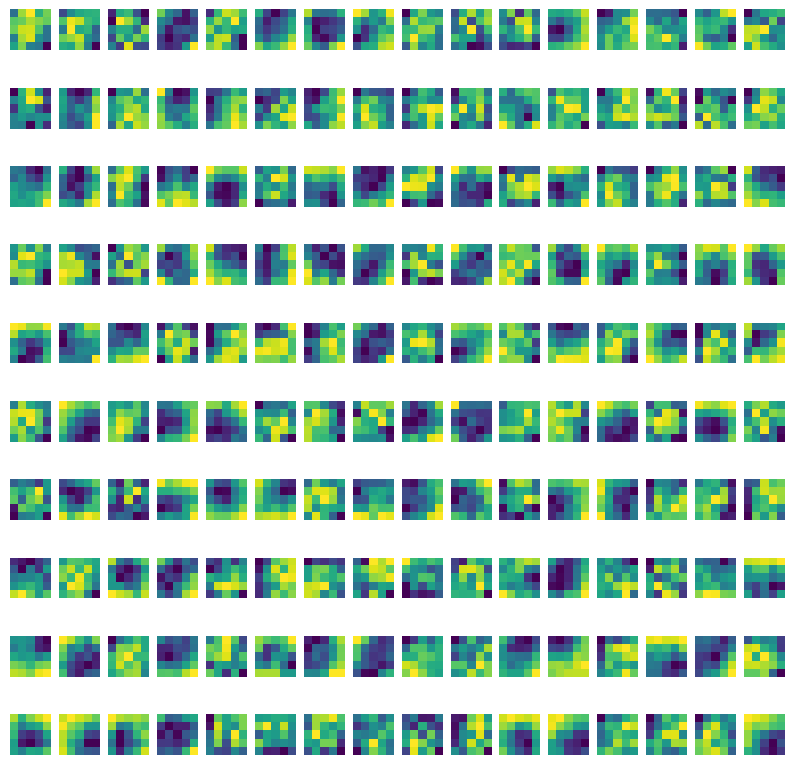

In [10]:
visualise_sampled_IID(10)

Visualising VAE sampled filters

In [17]:
import torch.nn as nn
x_dim  = 25
hidden_dim = 10
latent_dim = 5
vae_batch_size = 100
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [12]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

In [14]:
model.load_state_dict(torch.load('../data/vae_file.pt'))
model.eval()

Model(
  (Encoder): Encoder(
    (FC_input): Linear(in_features=25, out_features=10, bias=True)
    (FC_input2): Linear(in_features=10, out_features=10, bias=True)
    (FC_mean): Linear(in_features=10, out_features=5, bias=True)
    (FC_var): Linear(in_features=10, out_features=5, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (Decoder): Decoder(
    (FC_hidden): Linear(in_features=5, out_features=10, bias=True)
    (FC_hidden2): Linear(in_features=10, out_features=10, bias=True)
    (FC_output): Linear(in_features=10, out_features=25, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)

In [18]:
with torch.no_grad():
    noise = torch.randn(vae_batch_size, latent_dim).to(device)
    generated_images =  model.Decoder(noise)
    # net[0].weight[c,:,:,:] = generated_filter[0].view(5, 5)


In [19]:
def show_image(x, idx):
    x = x.view(vae_batch_size, 5, 5)
    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

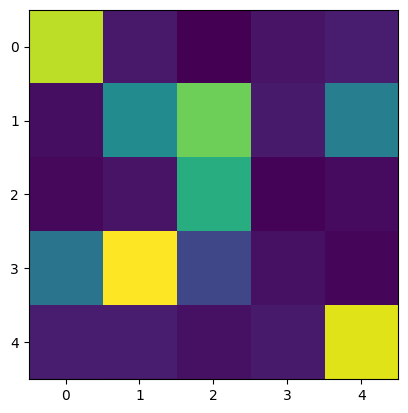

In [20]:
show_image(generated_images, idx=12)

In [22]:
def visualise_vae(num_rows, generated_images):
  _, axarr = plt.subplots(num_rows, 16, figsize=(10, num_rows))

  x = generated_images
  x = x.view(vae_batch_size, 5, 5)

  for i in range(num_rows):
    for j in range(16):
      axarr[i, j].set_axis_off()
      axarr[i, j].imshow(x[16*i+j].cpu().numpy(), interpolation=None)

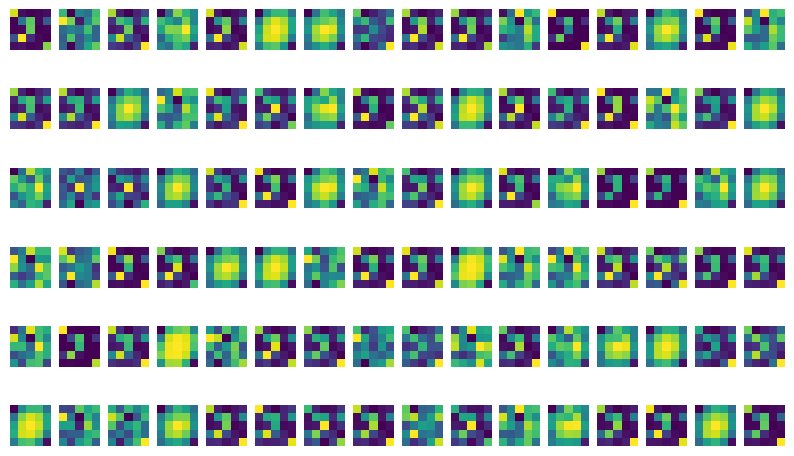

: 

In [23]:
visualise_vae(100//num_filters, generated_images)